<a href="https://colab.research.google.com/github/Beatriz-Yun/AIFFEL_LMS/blob/main/Exploration/%5BE-05%5D%EC%96%BC%EA%B5%B4%EC%9E%84%EB%B2%A0%EB%94%A9_%EB%B0%8F_%EC%9C%A0%EC%82%AC%EB%8F%84_%EC%B8%A1%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 학습목표
- 임베딩에 대해 이해하고 얼굴의 임베딩 벡터를 추출합니다.
- 얼굴의 임베딩 벡터로 닮은 꼴인 얼굴을 찾습니다.
- 나와 가까운 연예인을 찾아냅니다.

벡터 공간에 우리가 표현하고자 하는 정보를 매핑함으로써 컴퓨터에게 정보를 전달한다.

<br>

즉 '얼굴이 얼마나 닮았나'하는 문제는 **'두 얼굴 벡터간 거리가 얼마나 되나'**하는 문제로 볼 수 있다.<br>
여기서 중요한 것은 **두 데이터 사이의 유사도를 어떻게 측정**할 것인가이다.
1. 픽셀 단위로 비교하는 방식
 - 단순한 변환에 취약하다. (shift, 회전 등)
2. 임베딩 벡터를 비교한다.
 - **임베딩: 이미지벡터를 저차원으로 변환**해서 필요한 정보를 보존한다.
  - 임베딩 벡터에 보존되는 필요한 정보란? **'상대적인 비교 수치'**


[개요: 머신러닝을 위한 특성 임베딩 추출 및 제공](https://cloud.google.com/architecture/overview-extracting-and-serving-feature-embeddings-for-machine-learning?hl=ko)

<br>

> **임베딩 기법을 활용하여 표현할 수 있는 데이터 유형**<br>
- 텍스트(단어, 문장, 전체 문서), 이미지, 오디오 등과 같은 구조화되지 않은 데이터
- 그래프 및 네트워크와 같은 복잡한 구조 데이터. 예: 소셜 네트워크 및 생화학 화합물
- 텍스트 설명을 사용한 이미지 검색 및 이미지 캡션 작성과 같은 다중 모달 변환 위치 및 점유와 같은 희소 특성(이를 밀집 특성으로 변환)
- 인구통계, 사회, 금융, 행동 속성이 300개 이상 포함된 고객 레코드와 같은 고차원 항목(이러한 항목을 보다 간결한 표현으로 변환)




<br>

임베딩 벡터간의 거리가 얼굴 임베딩 벡터 사이의 유사도를 반영하도록 딥러닝을 통해 학습하는 사례를 보자.

## 얼굴임베딩 만들기(1): 얼굴인식

dlib를 사용해 만들어진 **'Face Recognition라이브러리'**를 사용해 얼굴을 인식한다.<br><br>

> **'dlib'**은 아주 널리 쓰이는 **Object Detection패키지**이다.<br>
dlib에 이미 face detector기능을 제공하지만 Face Recognition라이브러리가 인식과 비교를 쉽게 사용할 수 있도록 구성되어 있어서 사용했다.<br>
(dlib의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM의 sliding window로 얼굴을 찾는다.)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


file_list: ['biden.jpg', 'bush.jpeg', 'clinton.jpeg', 'obama.jpg', 'reagan.jpg', 'trump.jpg']


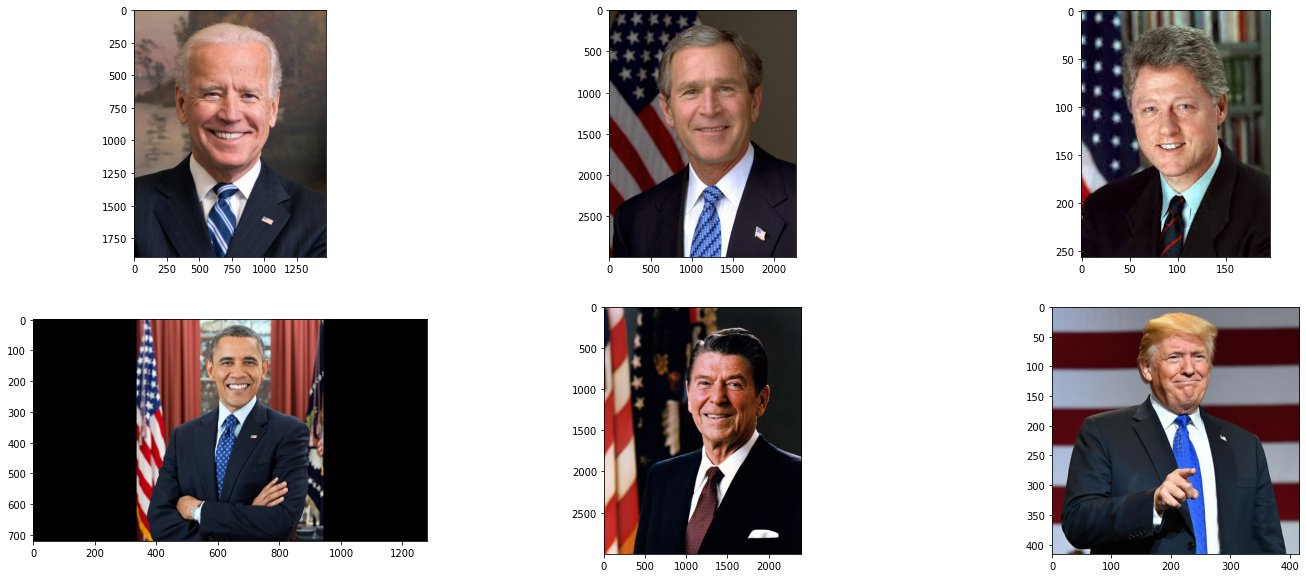

In [4]:
import os

dir_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/images'
file_list = os.listdir(dir_path)

# 이미지 파일명 출력
print ("file_list: {}".format(file_list))

# 시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib.image as img

#figsize 설정
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,10))

print(axes.flatten())
# axes.flatten()을 통해 subplot을 1차원으로 반복한다
for i, ax in enumerate(axes.flatten()):
  image = img.imread(dir_path+'/'+file_list[i])
  ax.imshow(image)
plt.show()

fig.tight_layout()

In [6]:
!pip3 install face_recognition

     |████████████████████████████████| 100.1 MB 21 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=babc7f02ad2bbbe15beb16376c8066e62518ea6872fa7f3459ee7abaf395e1fc
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


face_recognition라이브러리를 사용하여 얼굴영역만 잘라서 출력하기

[(98, 758, 284, 572)]


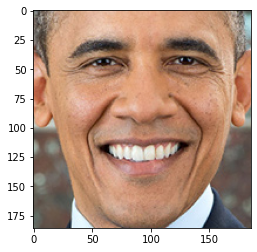

In [7]:
import face_recognition
import os
%matplotlib inline
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/images/obama.jpg'
image = face_recognition.load_image_file(image_path)
face_locations = face_recognition.face_locations(image)

print(face_locations)           # 이미지에서 얼굴 영역의 좌표를 출력합니다.

a, b, c, d = face_locations[0]  # left, bottom, right, top
cropped_face = image[a:c,d:b,:]

plt.imshow(cropped_face)        # 이미지에서 얼굴영역만 잘라낸 cropped_face를 그려 봅니다.

위의 과정을 함수로 작성하여 사용하기

In [8]:
import face_recognition
import os

def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

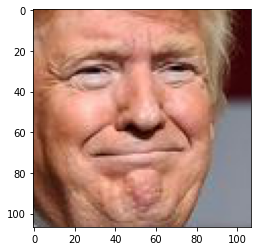

In [9]:
image_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/images/trump.jpg'

cropped_face = get_cropped_face(image_path)
plt.imshow(cropped_face)

## 얼굴임베딩 만들기(2): FaceNet

FaceNet은 2015년 구글에서 발표한 딥러닝 모델이다.<br>
![이미지](https://drive.google.com/uc?id=14711tHBoYuNO0ddp3Fj9Eu-L2gB1QQi8)

네트워크 뒤에 **L2 Normalization**을 거쳐 임베딩을 만들어 내고 여기에 **Triplet Loss**를 사용한다.
- **L2 Normalization**은 모델 결과물의 L2 Distance를 구한 후에 이것으로 결과물을 나눠주어 Normalization을 해주는 과정이다.
- **Triplet Loss**은 세 개의 데이터 쌍을 이용해 계산하는 손실함수이다.
 - 얼굴 데이터셋에서 A와 C는 같은 사람의 얼굴 사진에서 나온 임베딩 벡터, B는 다른 사람의 얼굴 사진에서 나온 임베딩 벡터가 되로록 데이터셋을 구성한다.
 - 이 때 **'A는 B에 비해 C에 더 가깝다'**는 논리가 성립해야 한다.
 - 같은 사람은 이 임베딩 벡터 A-C 간의 거리를 가깝게 / 다른 사람의 임베딩 벡터 B-C 간의 거리를 멀게 학습을 시키는 효과를 낸다.

<br>

[Triplet loss를 사용한 FaceNet 방법을 제시한 Florian Schroff 등의 논문](https://arxiv.org/abs/1503.03832)

[Triplet loss설명 영상](https://www.youtube.com/watch?v=d2XB5-tuCWU&ab_channel=DeepLearningAI)

In [10]:
import os

dir_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/images'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

file_list: ['biden.jpg', 'bush.jpeg', 'clinton.jpeg', 'obama.jpg', 'reagan.jpg', 'trump.jpg']


이미지에서 얼굴영역을 자른 부분으로 임베딩벡터로 인코딩한다.
- face_recognition라이브러리의 face_encodings함수를 사용

In [13]:
image_file = os.path.join(dir_path, 'obama.jpg')
face = get_cropped_face(image_file)   # 이미지에서 얼굴영역을 자른 함수 호출

# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)   # 인코딩

embedding = get_face_embedding(face)
print(len(embedding[0]))                           # 임베딩벡터는 128차원이다.
embedding

128


[array([-0.08126254,  0.11014756, -0.01082434, -0.05268792,  0.01033733,
        -0.0081381 , -0.07251763, -0.09226447,  0.19304717, -0.09246377,
         0.23908521,  0.06770286, -0.2212313 , -0.14119361,  0.05562158,
         0.13705495, -0.17924419, -0.07232306, -0.1118328 , -0.11370808,
         0.03956439, -0.01019117,  0.09421782,  0.04493129, -0.12757553,
        -0.34449607, -0.05374933, -0.17703304,  0.00868219, -0.09721589,
        -0.09817185,  0.00278223, -0.17721349, -0.12789799,  0.0348983 ,
        -0.01991227, -0.00838926, -0.00132864,  0.18308598,  0.02447565,
        -0.12376569,  0.0995703 ,  0.02323568,  0.22983313,  0.28385246,
         0.06655722, -0.00558913, -0.09833538,  0.10058984, -0.23476952,
         0.06006299,  0.13415912,  0.08373027,  0.03900497,  0.10194538,
        -0.19337651,  0.01717631,  0.0897897 , -0.1600512 ,  0.01892103,
         0.03082441, -0.06051283, -0.04526768,  0.04633338,  0.20678683,
         0.10299791, -0.12437537, -0.0490515 ,  0.1

디렉토리에 있는 모든 이미지파일에 대하여<br>
미리 작성했던 얼굴영역을 자르는 함수get_cropped_face를 호출한 후<br>
얼굴영역을 임베딩벡터로 인코딩하는 함수get_face_embedding을 호출하는 과정을 반복하는 함수를 작성한다.<br><br>

사람 이름을 key, 임베딩벡터를 value로 가지는 딕셔너리를 반환한다.

In [15]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다.
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        
    return embedding_dict

In [16]:
embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['trump']

array([-0.15962465,  0.20268653,  0.03236368,  0.02439236, -0.06226429,
        0.05140708,  0.07351795, -0.16823344,  0.06962213, -0.05557962,
        0.17270115, -0.05094168, -0.35293114, -0.03164374,  0.0379298 ,
        0.17343853, -0.13260117, -0.15357378, -0.23523533, -0.08442686,
       -0.00134148,  0.0321067 , -0.08926149, -0.0267079 , -0.09581175,
       -0.25792351, -0.01057006, -0.11071659,  0.03133575, -0.0744492 ,
        0.05670554, -0.02273792, -0.19461147, -0.04576051,  0.00947583,
        0.01806067, -0.15026242, -0.0778732 ,  0.17577612,  0.01933256,
       -0.19744582, -0.03930522,  0.07374461,  0.20196025,  0.14767551,
       -0.01415388,  0.01724749, -0.11976211,  0.0946297 , -0.24318154,
       -0.0275512 ,  0.12169901,  0.14837697,  0.17079787,  0.06952564,
       -0.15360463,  0.02005425,  0.08199155, -0.19544819,  0.10653647,
        0.11468481, -0.21902826, -0.07677589, -0.06791048,  0.105876  ,
        0.05921572, -0.061157  , -0.11171091,  0.23917486, -0.15

##  얼굴 임베딩벡터 사이의 거리 측정
임베딩 벡터를 실제로 구해보았으니, 임베딩 공간 속에서 **임베딩 벡터들의 거리가 어떤 의미인지** 알아보자.

In [17]:
import numpy as np

# 미리 세 사람의 사진을 Face Detection모델로 잘라서 128차원의 임베딩벡터로 추출한 결과
# 리스트를 ndarray로 변환
# ---> B와 C는 같은 사람의 얼굴 임베딩벡터이다.

A = np.array([0.0019173615146428347, 0.17689529061317444, 0.0763588473200798, -0.024574430659413338, -0.13141091167926788, 0.0344821996986866, -0.0374063216149807, -0.07056370377540588, 0.048655178397893906, -0.03414120525121689, 0.22696012258529663, -0.061402369290590286, -0.24329672753810883, -0.039421431720256805, 0.0621466189622879, 0.1220191940665245, -0.1616966724395752, -0.06176016479730606, -0.18894734978675842, -0.06051916256546974, -0.010404378175735474, -0.05918719246983528, 0.02205268107354641, -0.06932859122753143, -0.20260301232337952, -0.2425234317779541, -0.04454419016838074, -0.11400106549263, -0.02022719383239746, -0.15134216845035553, 0.07622595876455307, -0.0323314443230629, -0.1404413878917694, -0.056338660418987274, -0.04520038887858391, -0.026131991297006607, -0.0352761372923851, -0.0679447203874588, 0.1318240910768509, 0.034210119396448135, -0.17475582659244537, 0.13853909075260162, -0.0027398746460676193, 0.227312833070755, 0.3029572069644928, 0.004932125099003315, 0.05853061378002167, -0.07521739602088928, 0.1443275809288025, -0.2340908795595169, 0.030092637985944748, 0.040133409202098846, 0.1672351360321045, 0.05728958174586296, 0.11475440859794617, -0.07548368722200394, 0.040267568081617355, 0.16487033665180206, -0.21067440509796143, 0.036163005977869034, 0.051559075713157654, -0.05994952470064163, 0.029524143785238266, -0.04122130945324898, 0.13074155151844025, 0.1142958477139473, -0.00561982998624444, -0.09740489721298218, 0.18533651530742645, -0.10422169417142868, -0.11409182846546173, 0.02283927984535694, -0.08339140564203262, -0.13673236966133118, -0.3275497853755951, -0.0002689119428396225, 0.2842463254928589, 0.13883619010448456, -0.29149484634399414, -0.07276060432195663, -0.03179163485765457, 0.011192545294761658, 0.03802505508065224, 0.03392524644732475, -0.03972085565328598, -0.12013585865497589, -0.06272879987955093, -0.026893358677625656, 0.2430601865053177, -0.12022019177675247, -0.010466678068041801, 0.20199882984161377, 0.051095910370349884, -0.13243277370929718, 0.06056740880012512, -0.04802423343062401, -0.12318279594182968, -0.013157366774976254, -0.12076889723539352, -0.07183175534009933, -0.01982908323407173, -0.15032584965229034, -0.026652328670024872, 0.06820419430732727, -0.24668177962303162, 0.1818322390317917, -0.01959969662129879, -0.07208395004272461, -0.0680316612124443, -0.038368165493011475, 0.021410271525382996, 0.06388168036937714, 0.2293335199356079, -0.22541724145412445, 0.19133104383945465, 0.24343697726726532, -0.04034627974033356, 0.07534503191709518, 0.017645064741373062, 0.054646339267492294, -0.046512290835380554, 0.07076910138130188, -0.0960201621055603, -0.12610889971256256, -0.017934376373887062, -0.010262779891490936, 0.01885927841067314, 0.057148948311805725])

B = np.array([-0.08116298168897629, 0.1283080279827118, 0.024102725088596344, -0.03748808428645134, 0.06578215956687927, -0.07137967646121979, -0.10578329861164093, -0.0911930501461029, 0.19589228928089142, -0.09603863954544067, 0.2447616308927536, 0.07736924290657043, -0.17048686742782593, -0.1277867704629898, 0.06390697509050369, 0.12272421270608902, -0.19242052733898163, -0.08341517299413681, -0.11065894365310669, -0.09501136839389801, -0.010332206264138222, -0.008188878186047077, 0.08251037448644638, 0.04358505830168724, -0.1455313265323639, -0.3595622479915619, -0.07877802848815918, -0.18927346169948578, -0.0018955999985337257, -0.06280332803726196, -0.06073163449764252, 0.03181075677275658, -0.15109844505786896, -0.08682074397802353, 0.017340943217277527, -0.020879391580820084, 0.008258359506726265, 0.016738882288336754, 0.16803768277168274, 0.039162665605545044, -0.09613757580518723, 0.06231086328625679, 0.00924085732549429, 0.2418847680091858, 0.26051488518714905, 0.07355985790491104, 0.05239278823137283, -0.08052310347557068, 0.08884726464748383, -0.24261267483234406, 0.05618546903133392, 0.12175332009792328, 0.09056758135557175, 0.04266638681292534, 0.16591356694698334, -0.2005864679813385, 0.01018378883600235, 0.08819808065891266, -0.15550008416175842, 0.0815843716263771, 0.03018287755548954, -0.025435002520680428, -0.06714558601379395, 0.009693139232695103, 0.22243273258209229, 0.13470745086669922, -0.1363328993320465, 0.01635543815791607, 0.18212205171585083, -0.03392908349633217, 0.0398673489689827, 0.0043264636769890785, -0.15493592619895935, -0.2530894875526428, -0.23155181109905243, 0.0678660124540329, 0.31580865383148193, 0.21846994757652283, -0.20842058956623077, 0.012199334800243378, -0.12194785475730896, 0.059383176267147064, 0.0768171101808548, -0.012840969488024712, -0.11975857615470886, -0.11892750859260559, -0.03087366186082363, 0.04432998597621918, 0.09186872839927673, 0.0821407362818718, -0.018520792946219444, 0.1962793618440628, -0.0566205158829689, 0.026071354746818542, 0.007139421068131924, 0.02185123600065708, -0.11292634904384613, -0.044381096959114075, -0.18024618923664093, -0.007845945656299591, 0.010368190705776215, -0.07480168342590332, -0.0035089245066046715, 0.09972234815359116, -0.18773995339870453, 0.0474785715341568, 0.025760797783732414, -0.042169712483882904, 0.0014017894864082336, 0.1201503798365593, -0.05088714882731438, -0.02051539719104767, 0.0884844958782196, -0.2176845818758011, 0.25695914030075073, 0.23358485102653503, 0.019985560327768326, 0.17838242650032043, 0.029055196791887283, 0.04518195986747742, -0.044122979044914246, -0.043431997299194336, -0.15906637907028198, -0.07155231386423111, 0.02525237947702408, 0.02502967044711113, 0.04127159342169762, 0.011846683919429779])

C = np.array([-0.0762145072221756, 0.09951083362102509, 0.0012626983225345612, -0.05529194697737694, -0.006535547785460949, -0.012212716042995453, -0.07667708396911621, -0.07388101518154144, 0.18756520748138428, -0.07589773088693619, 0.2424328476190567, 0.06438330560922623, -0.22197730839252472, -0.13409815728664398, 0.046808283776044846, 0.14692817628383636, -0.1844339370727539, -0.051137253642082214, -0.1149090975522995, -0.1297808736562729, 0.040612753480672836, -0.002555673476308584, 0.10426937788724899, 0.026295233517885208, -0.13127824664115906, -0.35947439074516296, -0.048153407871723175, -0.17165206372737885, -0.0002263905480504036, -0.10254599899053574, -0.08338439464569092, 0.014203382655978203, -0.18179851770401, -0.13200539350509644, 0.03813670203089714, -0.012789442203938961, -0.0030085663311183453, -0.007307708729058504, 0.17558619379997253, 0.025768719613552094, -0.12877899408340454, 0.11051110923290253, 0.03616628795862198, 0.22539083659648895, 0.2838597595691681, 0.07483825087547302, -0.0036694444715976715, -0.09967216849327087, 0.11106447875499725, -0.22961333394050598, 0.06397823244333267, 0.12394970655441284, 0.06568531692028046, 0.037825535982847214, 0.09586739540100098, -0.18721607327461243, 0.01674063131213188, 0.10057111084461212, -0.15766742825508118, 0.008397659286856651, 0.039109550416469574, -0.06041106954216957, -0.046033550053834915, 0.031240269541740417, 0.2121172845363617, 0.103468157351017, -0.1224282756447792, -0.05559460073709488, 0.12153220176696777, -0.018480442464351654, 0.039875734597444534, 0.007489997893571854, -0.18950346112251282, -0.20904967188835144, -0.23732705414295197, 0.0895664244890213, 0.3778454661369324, 0.16606193780899048, -0.20442475378513336, 0.018602905794978142, -0.18367978930473328, 0.04945264756679535, 0.08889186382293701, 0.002995049115270376, -0.06196683272719383, -0.13028381764888763, -0.03548961132764816, 0.053789377212524414, 0.08386979252099991, 0.016627438366413116, -0.040179431438446045, 0.2289249151945114, -0.02149147540330887, 0.05046383664011955, 0.02314644865691662, 0.05424635857343674, -0.1627081036567688, -0.01140156015753746, -0.18031321465969086, -0.06785157322883606, 0.03336677327752113, -0.06467186659574509, 0.0466950424015522, 0.12832939624786377, -0.2377130389213562, 0.06774994730949402, 0.013810726813971996, -0.019034255295991898, 0.04477768391370773, 0.0660984218120575, -0.031004268676042557, -0.03275192156434059, 0.06632497161626816, -0.24120087921619415, 0.2647172510623932, 0.2477877289056778, 0.054315339773893356, 0.17328208684921265, 0.06950142979621887, 0.019016757607460022, -0.01211759727448225, -0.014044362120330334, -0.17701464891433716, -0.03347969055175781, 0.04914966598153114, 0.05660251900553703, 0.0644666999578476, 0.012375651858747005])

**np.linalg.norm**을 사용하여 거리를 계산하자.

[공식문서) numpy.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

다음은 L1, L2 거리를 구하는 예제이다.

In [25]:
import numpy as np

x = np.array([1,2,3,4,5])
y = np.array([2,3,4,5,6])

print(np.linalg.norm(y-x, ord=1))  #L1 distance
print(np.linalg.norm(y-x, ord=2))  #L2 distance

5.0
2.23606797749979


임베딩 벡터 A,B,C에 대하여 L2 Norm 거리 계산

In [23]:
print(([A, B] - C).shape)
distances = np.linalg.norm([A, B] - C, axis=1, ord=2)         # ord=2는 L2 norm을 의미한다.
print("Distance between A and C: {}".format(distances[0]))
print("Distance between B and C: {}".format(distances[1]))    # 같은 사람인 B와 C의 거리가 더 가깝다.

(2, 128)
Distance between A and C: 0.8211549091846528
Distance between B and C: 0.34743558135053815


임베딩 벡터 A,B,C에 대하여 L1 Norm 거리 계산
- L2 거리에 비해 전체적인 거리값의 분포가 커진다.

In [24]:
distances = np.linalg.norm([A, B] - C, axis=1, ord=1)        # ord=1은 L1 norm을 의미한다.
print("Distance between A and C: {}".format(distances[0]))
print("Distance between B and C: {}".format(distances[1]))

Distance between A and C: 7.720474720699713
Distance between B and C: 3.1546838842332363


위의 방법들을 참고하여 사람이름 2개를 넣으면 L2거리를 반환하는 함수를 작성한다.

In [21]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

get_distance('obama', 'trump')

0.888511807112004

## 얼굴 임베딩 공간의 시각화

128차원의 벡터를 시각화할 수 없기 때문에<br>
고차원 데이터를 저차원으로 바꿔서 시각화하기 위해 **차원 축소** 방법인 **PCA, T-SNE** 등을 사용한다.
- **tensoflor의 Projector**는 <u>고차원 벡터를 차원 축소 기법을 사용해서 시각화</u>할 수 있게 해준다.<br>[128차원 FaceNet LFW Embedding Visualization](https://huyhoang17.github.io/128D-Facenet-LFW-Embedding-Visualisation/)

<br>

1.**PCA (주성분분석)**: 모든 차원의 축에 따른 값의 분산을 확인해서 그 중 변화(분산)가 가장 큰 주요한 축을 남기는 방법이다.<br>[차원 감소와 PCA 분석](https://bcho.tistory.com/1209?category=555440)

2.**T-SNE**: 고차원 상에서 먼 거리를 저차원 상에서도 멀리 배치되도록 차원을 축소하는 방식이다.<br>먼저 random하게 목표하는 차원에 데이터들을 배치한 후 각 데이터들을 고차원 상에서의 배치와 비교를 하면서 위치를 변경해 준다.<br>
[T-SNE 설명 영상](https://www.youtube.com/watch?v=NEaUSP4YerM&ab_channel=StatQuestwithJoshStarmer)

지금까지 구현한 함수들:
- $get\_cropped\_face(imge\_file)$: 이미지 파일에서 얼굴 영역을 가져오는 함수
- $get\_face\_embedding(face)$: 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
- $get\_face\_embedding\_dict(dir\_path)$: 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수
- $get\_distance(name1, name2)$: 두 이미지(사람 이름) 사이의 임베딩 벡터 거리를 구하는 함수

<br>

이제 특정 이미지와 가장 닮은 이미지를 구해보는 기능을 만들 수 있다.

In [27]:
# name1과 name2의 거리를 비교하는 함수를 생성하되
# name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

sort_key_func = get_sort_key_func('trump')   
# 이렇게 생성된 함수 sort_key_func는 sort_key_func('obama') 라고 호출할 때 trump와 obama 사이의 임베딩 벡터 거리를 계산합니다.

In [28]:
sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))

[('trump',
  array([-0.15962465,  0.20268653,  0.03236368,  0.02439236, -0.06226429,
          0.05140708,  0.07351795, -0.16823344,  0.06962213, -0.05557962,
          0.17270115, -0.05094168, -0.35293114, -0.03164374,  0.0379298 ,
          0.17343853, -0.13260117, -0.15357378, -0.23523533, -0.08442686,
         -0.00134148,  0.0321067 , -0.08926149, -0.0267079 , -0.09581175,
         -0.25792351, -0.01057006, -0.11071659,  0.03133575, -0.0744492 ,
          0.05670554, -0.02273792, -0.19461147, -0.04576051,  0.00947583,
          0.01806067, -0.15026242, -0.0778732 ,  0.17577612,  0.01933256,
         -0.19744582, -0.03930522,  0.07374461,  0.20196025,  0.14767551,
         -0.01415388,  0.01724749, -0.11976211,  0.0946297 , -0.24318154,
         -0.0275512 ,  0.12169901,  0.14837697,  0.17079787,  0.06952564,
         -0.15360463,  0.02005425,  0.08199155, -0.19544819,  0.10653647,
          0.11468481, -0.21902826, -0.07677589, -0.06791048,  0.105876  ,
          0.05921572, -0.06

In [30]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(1, top+1):   # 첫번째로 나오는 이름은 자기 자신이므로 제외한다. 
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

# obama와 가장 닮은 사람은 누굴까요?
get_nearest_face('obama')

순위 1 : 이름(biden), 거리(0.8467205554614515)
순위 2 : 이름(bush), 거리(0.8628474536945554)
순위 3 : 이름(reagan), 거리(0.8692437108490952)
순위 4 : 이름(trump), 거리(0.888511807112004)
순위 5 : 이름(clinton), 거리(0.90009982191251)
